In [11]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from pandas import DataFrame
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA # PCA
from sklearn.preprocessing import scale # для предобработки изображений, масштаб
from time import time

In [12]:
# нужно разбить цены на данные классы
classes =  [(0, 12000),
           (12000, 46000)]

dataset = pd.read_csv('car19.csv')
price = dataset[['price']]
categories = []
doneFlag = False
for _, x in price.iterrows():
    for i, c in enumerate(classes):

        if c[0] <= x['price'] < c[1]:
            categories.append(i)
            breakFlag = True
            break

    if doneFlag:
        continue
dataset['Категория'] = categories
# берём колонки которые извлекли в 13 лабе
dataset = dataset[['wheelbase', 'carlength', 'enginesize', 'compressionratio',
       'horsepower', 'Категория']]

In [13]:
dataset.head(100)

,wheelbase,carlength,enginesize,compressionratio,horsepower,Категория
0,88.6,168.8,130,9.0,111,1
1,88.6,168.8,130,9.0,111,1
2,94.5,171.2,152,9.0,154,1
3,99.8,176.6,109,10.0,102,1
4,99.4,176.6,136,8.0,115,1
...,...,...,...,...,...,...
95,100.4,184.6,181,9.0,152,1
96,91.3,170.7,181,9.0,160,1
97,91.3,170.7,181,7.8,200,1
98,99.2,178.5,181,9.0,160,1


In [14]:
X = dataset[dataset.columns.drop(labels='Категория')]
Y = dataset[['Категория']]

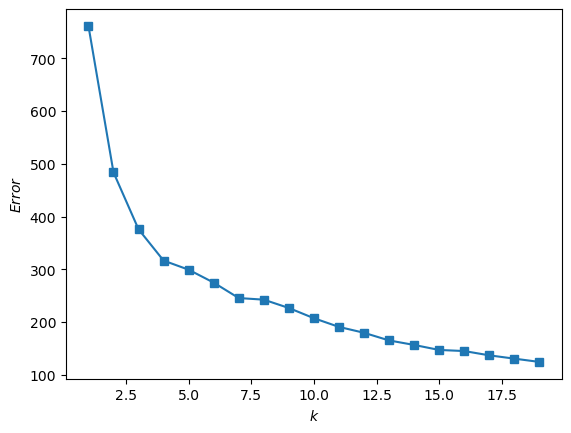

In [5]:
inertia = [] # здесь будем накапливать ошибки
for k in range(1, 20): #
    kmeans = KMeans(n_clusters=k, random_state=1, n_init='auto').fit(X) # создаем и обучаем кластеризатор с заданным числом кластеров
    inertia.append(np.sqrt(kmeans.inertia_)) # смотрим на ошибку, добавляем ее в историю

plt.plot(range(1, 20), inertia, marker='s') # строим график ошибки
plt.xlabel('$k$') #
plt.ylabel('$Error$'); #

In [6]:
# настройка K-Means
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=40, n_init=10)
# Вычислить центры кластеров и спрогнозировать индекс кластера для каждой выборки.
kmeans.fit(X)
y_kmeans = kmeans.fit_predict(X)
# центры кластеров
print(kmeans.cluster_centers_)

[[ 99.48333333 180.02333333 163.1          8.90333333 155.03333333]
 [ 98.33188406 174.8115942  118.72463768   8.68855072  98.68115942]
 [107.98571429 193.45714286 270.14285714   8.85714286 203.57142857]
 [ 93.98113208 160.7         91.49056604   9.5190566   69.60377358]]


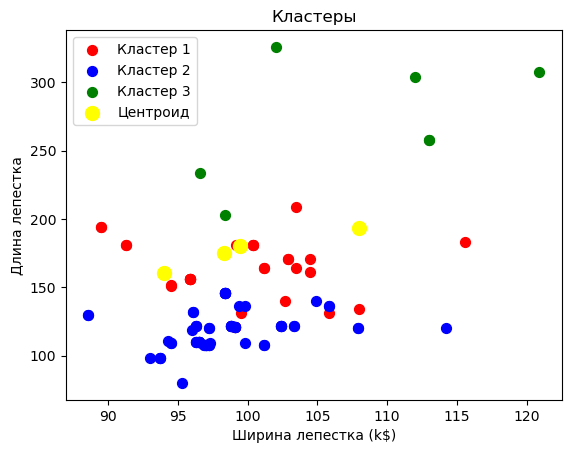

In [7]:
# визуализация кластеров
plt.scatter(X[y_kmeans == 0]['wheelbase'], X[y_kmeans == 0]['enginesize'], s = 50, c = 'red', label = 'Кластер 1')
plt.scatter(X[y_kmeans == 1]['wheelbase'], X[y_kmeans == 1]['enginesize'], s = 50, c = 'blue', label = 'Кластер 2')
plt.scatter(X[y_kmeans == 2]['wheelbase'], X[y_kmeans == 2]['enginesize'], s = 50, c = 'green', label = 'Кластер 3')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'yellow', label =
'Центроид')
plt.title('Кластеры')
plt.xlabel('Ширина лепестка (k$)')
plt.ylabel('Длина лепестка')
plt.legend(loc='best')
plt.show()

In [8]:
kl=kmeans.labels_.reshape(-1,1)
y_new=Y.values.reshape(-1, 1)
z=np.hstack((X, y_new, kl))
z=DataFrame(z,columns=['wheelbase',
                       'carlength',
                       'enginesize',
                       'compressionratio',
                       'Категория',
                        'horsepower',
                       'claster'])
z

,wheelbase,carlength,enginesize,compressionratio,Категория,horsepower,claster
0,88.6,168.8,130.0,9.0,111.0,1.0,1.0
1,88.6,168.8,130.0,9.0,111.0,1.0,1.0
2,94.5,171.2,152.0,9.0,154.0,1.0,0.0
3,99.8,176.6,109.0,10.0,102.0,1.0,1.0
4,99.4,176.6,136.0,8.0,115.0,1.0,1.0
...,...,...,...,...,...,...,...
154,104.5,187.8,171.0,9.2,156.0,1.0,0.0
155,104.5,187.8,161.0,9.2,156.0,1.0,0.0
156,97.3,171.7,109.0,9.0,85.0,0.0,1.0
157,94.5,159.3,109.0,8.5,90.0,0.0,1.0


## Расчет метрик

In [9]:
# функция для расчета метрик
def bench_k_means(estimator, name, data):
    # принимает кластеризатор, его название, данные
    t0 = time() # старт таймера
    estimator.fit(data) # обучаем кластеризатор
    # вычисляем метрики и отображаем их
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

In [10]:
data = scale(X) # предобработка, масштабируем данные, приводя к нулевому среднему и единичной дисперсии

n_samples, n_features = data.shape # число примеров и число признаков
n_digits = len(np.unique(Y)) # число уникальных классов
labels = Y.values.ravel()
sample_size = 300

print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))

# заголовок для таблички результатов
print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')
# тест для k-means в котором используется улучшенный выбор начальной расстановки центроидов
bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)
# тест для k-means  в котором центроиды изначально выбраны случайно из данных
bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

# тест для k-means  в котором начальные центроиды выбраны как главные компоненты PCA
pca = PCA(n_components=n_digits).fit(data) # вычисляем главные компоненты
bench_k_means(KMeans(init=pca.components_, # используем главные компоненты как начальные положения центроидов
                     n_clusters=n_digits, n_init=1), # здесь начальные положения центроидов не изменяются, поэтому только 1 раз делаем кластеризацию
              name="PCA-based",
              data=data)
print(82 * '_')

n_digits: 2, 	 n_samples 159, 	 n_features 5
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.28s	505	0.523	0.527	0.525	0.654	0.523	0.412
random   	0.27s	505	0.523	0.527	0.525	0.654	0.523	0.412
PCA-based	0.03s	506	0.472	0.456	0.463	0.575	0.461	0.394
__________________________________________________________________________________
